# Prédiction de la consommation totale d'énergie

* Dans ce notebook nous préestons les prédictions sur la variable de consommation ébergetique ici **SiteEnergyUse(kBtu)** 

In [1]:
import pandas as pd
import numpy as np
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
#import sante as s
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
#from termcolor import colored
import math
from scipy import stats
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.impute import KNNImputer
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1)

In [2]:
#import batiment as b

In [3]:
import bat as bt 

## Préparation des données 

In [4]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv', sep = ",") 


### Suppression des colonnes inutiles 

In [5]:
data = bt.variable_to_drop(df)

In [6]:
data.shape

(995, 26)

In [7]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'DefaultData', 'ComplianceStatus',
       'TotalGHGEmissions'],
      dtype='object')

### âge des bâtiemnts

In [8]:
# Calculer l'âge en soustrayant chaque valeur de YearBuilt de 2016
data['Age'] = 2016 - data['YearBuilt']

# Réorganiser les colonnes pour placer "Age" avant "YearBuilt"
df = data[['Age'] + [col for col in data.columns if col != 'Age' and col != 'YearBuilt']]

In [9]:
numerical_features = data.select_dtypes(include=['int64','float64'])
categorical_features = data.select_dtypes(exclude=['int64','float64'])

In [10]:
data = data[data['SiteEnergyUseWN(kBtu)']<8*10**8]

In [11]:
data = data.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(therms)'], axis=1)

In [12]:
categorical_features.nunique()

BuildingType                    4  
PrimaryPropertyType             17 
Neighborhood                    18 
ListOfAllPropertyUseTypes       161
LargestPropertyUseType          21 
SecondLargestPropertyUseType    31 
ThirdLargestPropertyUseType     31 
DefaultData                     1  
ComplianceStatus                1  
dtype: int64

In [13]:
categorical_features = categorical_features.drop(['DefaultData' ,'ComplianceStatus'], axis=1)

In [15]:
numerical_features = numerical_features.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(therms)'], axis=1)

In [16]:
numerical_features.columns

Index(['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Age'],
      dtype='object')

#  émissions de CO2

### preprocessing 

In [17]:
#moi
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

numerical_features =['Age', 'NumberofBuildings', 'NumberofFloors',
                    'PropertyGFATotal', 'PropertyGFAParking','ENERGYSTARScore',
                    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)']
categorical_features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType']
    

variables_to_remove = ['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'] 
for variable in variables_to_remove:
    if variable in numerical_features:
        numerical_features.remove(variable)
    else:
        print(f"{variable} is not present in numerical_features list.")

X_train = train_data[numerical_features + categorical_features]
y_train = train_data['SiteEnergyUseWN(kBtu)']
X_test = test_data[numerical_features +categorical_features]
y_test = test_data['SiteEnergyUseWN(kBtu)']
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))


TotalGHGEmissions is not present in numerical_features list.
SiteEnergyUseWN(kBtu) is not present in numerical_features list.
Entrainement: 795 lignes,
Test: 199 lignes.



### prétraitement des variables catégorielles : encodage 

In [18]:


# Définir les étapes de prétraitement pour les variables numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Vous pouvez remplacer 'mean' par 'median', 'most_frequent', etc.
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes par la valeur la plus fréquente
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Créer un préprocesseur pour appliquer les étapes de prétraitement à chaque type de colonne
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features[:-1])  # Exclure la variable cible
    ])

# Adapter le préprocesseur aux données d'entraînement et transformer les données
X_train_final = preprocessor.fit_transform(train_data)
X_test_final = preprocessor.transform(test_data)


#### caractéristiques après le prétraitement

In [19]:
# Obtenir les noms des caractéristiques après le prétraitement
feature_names = preprocessor.get_feature_names_out()

# Afficher les noms des caractéristiques
#print(feature_names)

# Modèle Baseline : Régression linéaire multivariée    


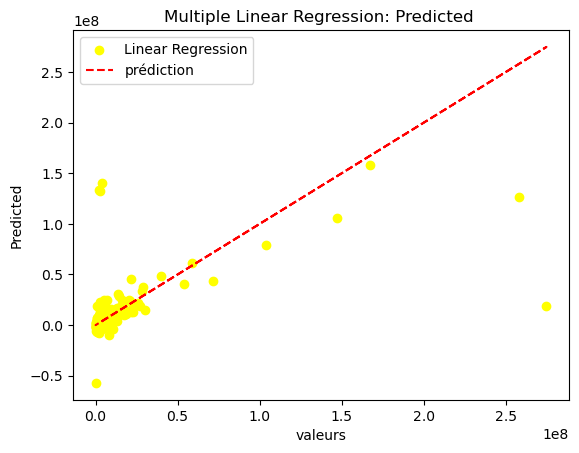

RMSE: 27427479.318951752
MAE: 9131643.28628418
R²: 0.26574579234971596


In [20]:

rmse, mae, r2 = bt.multiple_regression(X_train_final, X_test_final, y_train, y_test)

# Affichage des résultats
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Nous utiliserons les métiques suivantes:
    * Erreur quadratique moyenne (RMSE) 

* Erreur absolue moyenne (MAE)

* Coefficient de détermination (R²)

* Erreur relative moyenne (MRE) :

* Erreur de prédiction maximale (Max Error) 
* Écart type des scores de validation croisée
* MAE moyenne lors de la validation croisée
* R² moyen lors de la validation croisée

### SVM

Métriques pour le SVM:
R² moyen lors de la validation croisée: -0.11534195410107731
MAE moyenne lors de la validation croisée: 7115175.554156217


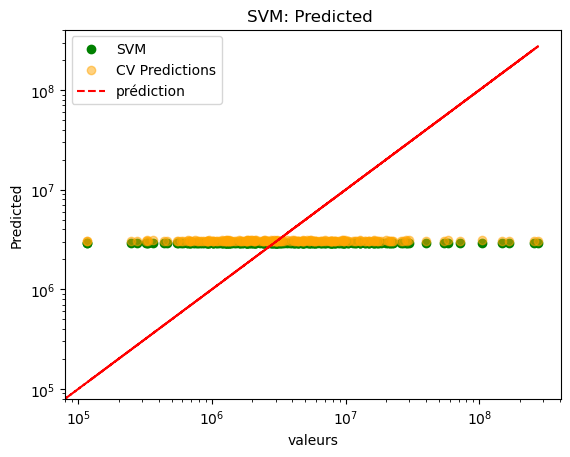

In [21]:
svm = bt.svm_regression(X_train_final, X_test_final, y_train, y_test)


In [22]:
from sklearn.svm import SVR


In [23]:
svm_regressor = SVR()
svm_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
y_pred = svm_regressor.predict(X_test_final)

In [24]:
#y_pred

* Sous-ajustement du modèle : Le modèle SVM peut être trop simple pour capturer les motifs complexes des données d'entraînement, ce qui entraîne des prédictions similaires pour différentes instances.

# Modèle non linéaire 

In [25]:
### Random fostrest 

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

def random_forest_regression_energy(X_train_final, X_test_final, y_train, y_test):
    """
    Effectue la régression avec un modèle de Random Forest.

    Args:
        X_train_final : Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final : Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.

    Returns:
        RandomForestRegressor: Le modèle de Random Forest entraîné.
    """
    
    # Créer et entraîner le modèle Random Forest
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = rf_regressor.predict(X_test_final)

    # Calculer les prédictions avec la validation croisée
    y_cv_pred = cross_val_predict(rf_regressor, X_test_final, y_test, cv=5)

    # Scatter plot avec ligne d'identité
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='green', alpha=0.5, label='Random Forest Predictions')
    plt.scatter(y_test, y_cv_pred, color='orange', alpha=0.5, label='CV Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    #plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('randomforest: Prediction')
    plt.legend()
    plt.savefig('scatter_plot_rf_vs_cv.png')
    plt.show()

    # Histogramme des résidus
    plt.figure(figsize=(8, 6))
    sns.histplot(y_test - y_pred, bins=30, kde=True, color='blue', alpha=0.5, label='RF Residuals')
    sns.histplot(y_test - y_cv_pred, bins=30, kde=True, color='yellow', alpha=0.5, label='CV Residuals')
    plt.xlabel('Résidus')
    plt.ylabel('Frequence')
    plt.title('Histogram des résidus du RF')
    plt.legend()
    plt.savefig('residuals_histogram_rf_vs_cv.png')
    plt.show()

    return rf_regressor


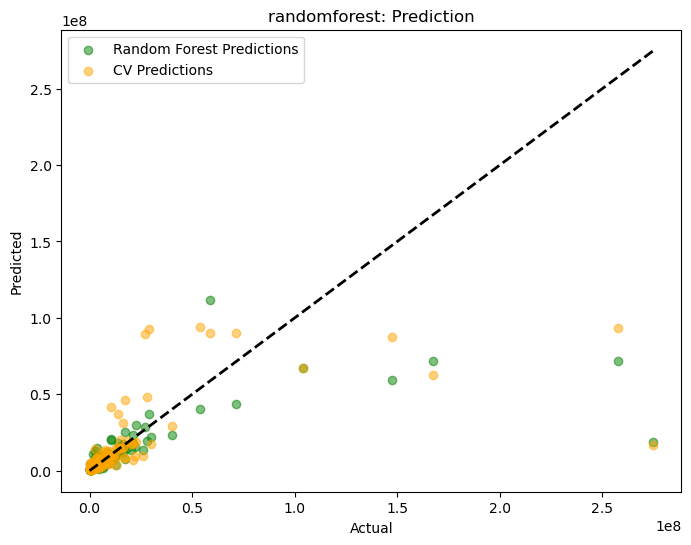

C:\ProgramData\anaconda\envs\cosy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda\envs\cosy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


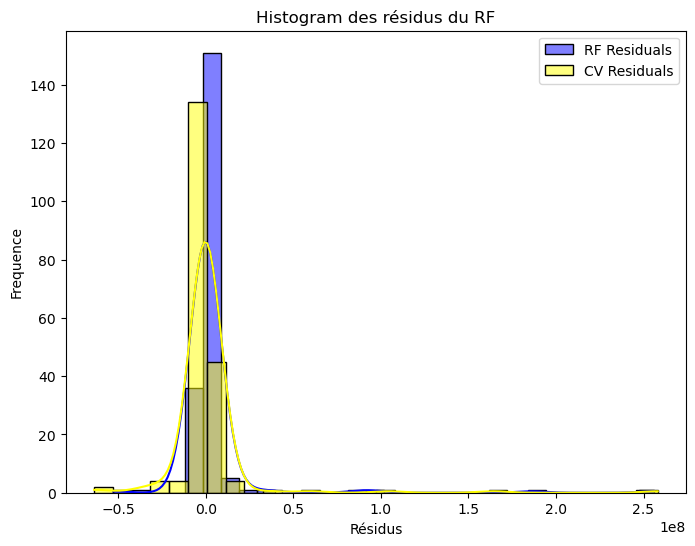

In [27]:
 foret_aléatoire = random_forest_regression_energy(X_train_final, X_test_final, y_train, y_test)


## RandomForestRegressor

Métriques pour le Random Forest:
R²: 0.3710078662452694
MAE: 5636018.625806171
RMSE: 25385474.255016353
Median Absolute Error: 953496.4124999996
Max Error: 255019741.99
R² moyen lors de la validation croisée: 0.6297265394721256
Écart type des scores de validation croisée: 0.17705587388453348
MAE moyenne lors de la validation croisée: 3380157.3788152174


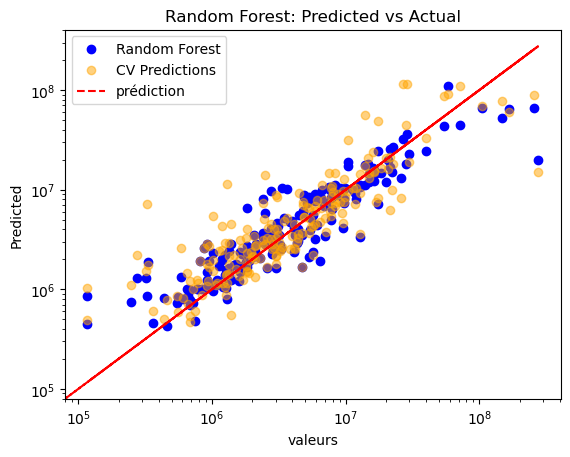

In [28]:
 foret_aléatoire = bt.random_forest_regression(X_train_final, X_test_final, y_train, y_test)


## xgboost

In [29]:
import xgboost as xgb

Métriques pour XGBoost:
R²: 0.4248416474989597
MAE: 5244418.350513898
RMSE: 24274840.767986212
Median Absolute Error: 861900.125
Max Error: 251160770.0
R² moyen lors de la validation croisée: 0.5886442399244457
Écart type des scores de validation croisée: 0.17581477078914215
MAE moyenne lors de la validation croisée: 3501060.22030661


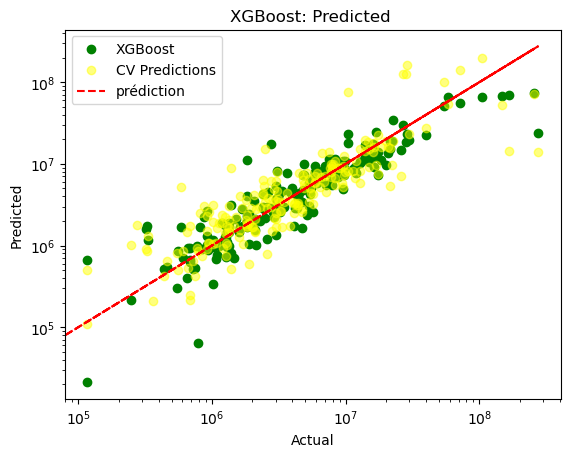

In [30]:
xgboost =  bt.xgboost_regression(X_train_final, X_test_final, y_train, y_test)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def xgboost_regression_energy(X_train_final, X_test_final, y_train, y_test):
    """
    Effectue la régression avec un modèle XGBoost.

    Args:
        X_train_final : Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final : Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.

    Returns:
        tuple: Un tuple contenant:
            - XGBRegressor: Le modèle XGBoost entraîné.
            
    """
    
    # Créer et entraîner le modèle XGBoost
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = xgb_regressor.predict(X_test_final)

    # Calculer les prédictions avec la validation croisée
    y_cv_pred = cross_val_predict(xgb_regressor, X_test_final, y_test, cv=5)

    # Scatter plot avec ligne d'identité
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='XGBoost Predictions')
    plt.scatter(y_test, y_cv_pred, color='red', alpha=0.5, label='CV Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    #plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter plot: Predicted vs Actual')
    plt.legend()
    plt.savefig('scatter_plot_xgboost_vs_cv.png')
    plt.show()

    # Histogramme des résidus
    plt.figure(figsize=(8, 6))
    sns.histplot(y_test - y_pred, bins=30, kde=True, color='blue', alpha=0.5, label='XGBoost Residuals')
    sns.histplot(y_test - y_cv_pred, bins=30, kde=True, color='red', alpha=0.5, label='CV Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    plt.legend()
    plt.savefig('residuals_histogram_xgboost_vs_cv.png')
    plt.show()


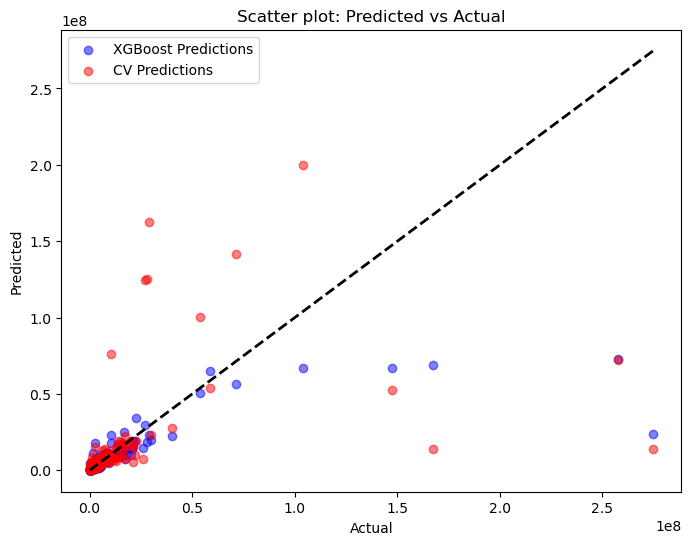

C:\ProgramData\anaconda\envs\cosy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda\envs\cosy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


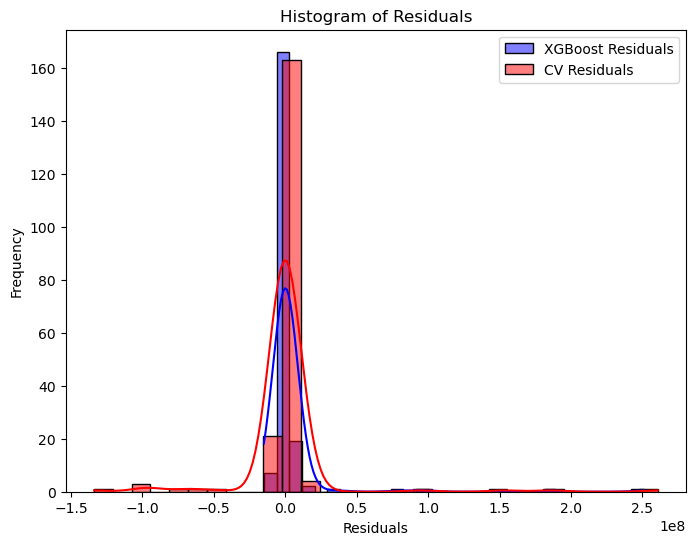

In [32]:
xgboost =  xgboost_regression_energy(X_train_final, X_test_final, y_train, y_test)


* le modèle ne capte pas les valeurs extremes 

In [33]:
## cnn

In [35]:
#cnn =  bt.neural_network_regression(X_train_final, X_test_final, y_train, y_test)


## feature importance pour la foret aléatoire 

Métriques pour le Random Forest:
R²: 0.3710078662452694
MAE: 5636018.625806171
RMSE: 25385474.255016353
Median Absolute Error: 953496.4124999996
Max Error: 255019741.99
R² moyen lors de la validation croisée: 0.6297265394721256
Écart type des scores de validation croisée: 0.17705587388453348
MAE moyenne lors de la validation croisée: 3380157.3788152174


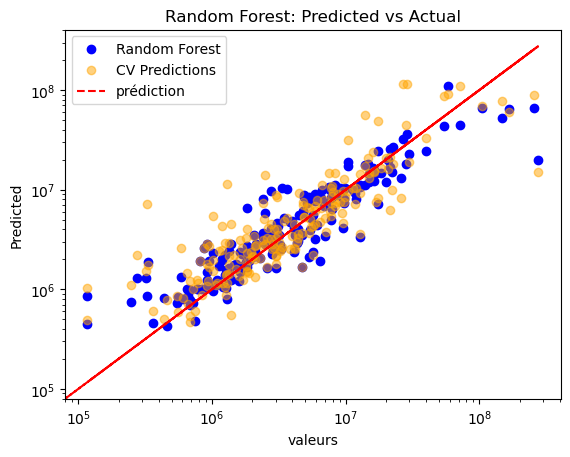

In [36]:
result = bt.random_forest_regression(X_train_final, X_test_final, y_train, y_test)

forest_model = result[0]
forest_y_pred = result[1]
forest_y_cv_pred = result[2]

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [38]:
feature_names = preprocessor.get_feature_names_out()

# Afficher les noms des caractéristiques
print(feature_names)

['num__Age' 'num__NumberofBuildings' 'num__NumberofFloors'
 'num__PropertyGFATotal' 'num__PropertyGFAParking' 'num__ENERGYSTARScore'
 'num__LargestPropertyUseTypeGFA' 'num__SecondLargestPropertyUseTypeGFA'
 'num__PropertyGFABuilding(s)' 'cat__BuildingType_Campus'
 'cat__BuildingType_NonResidential' 'cat__BuildingType_Nonresidential COS'
 'cat__BuildingType_SPS-District K-12'
 'cat__PrimaryPropertyType_Distribution Center'
 'cat__PrimaryPropertyType_Hospital' 'cat__PrimaryPropertyType_Hotel'
 'cat__PrimaryPropertyType_K-12 School'
 'cat__PrimaryPropertyType_Large Office'
 'cat__PrimaryPropertyType_Low-Rise Multifamily'
 'cat__PrimaryPropertyType_Medical Office'
 'cat__PrimaryPropertyType_Mixed Use Property'
 'cat__PrimaryPropertyType_Other'
 'cat__PrimaryPropertyType_Refrigerated Warehouse'
 'cat__PrimaryPropertyType_Residence Hall'
 'cat__PrimaryPropertyType_Retail Store'
 'cat__PrimaryPropertyType_Senior Care Community'
 'cat__PrimaryPropertyType_Small- and Mid-Sized Office'
 'cat__Pr

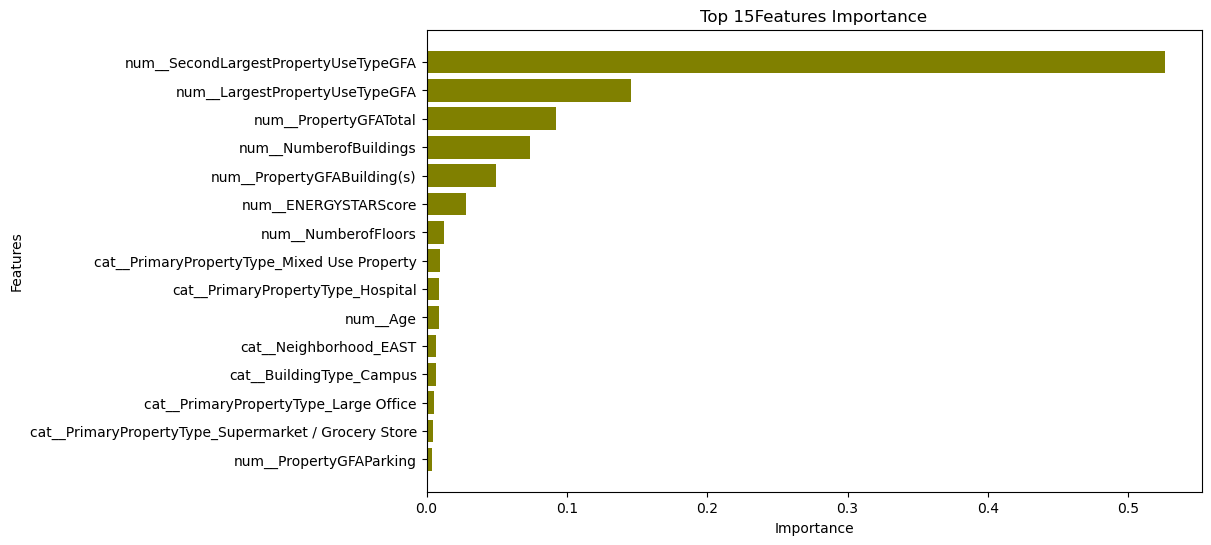

(RandomForestRegressor(random_state=42),
 array([1.02659214e+07, 3.40672102e+06, 2.85762940e+06, 8.60658819e+05,
        6.49575123e+06, 2.87142846e+06, 8.49724959e+06, 2.24682154e+06,
        5.84091388e+06, 8.55931836e+05, 1.92008372e+06, 2.10741303e+06,
        1.20534180e+06, 1.82911182e+07, 1.12001562e+07, 3.29762794e+06,
        1.12343408e+06, 1.20098265e+07, 1.08986140e+08, 3.33824725e+06,
        6.55690260e+07, 3.53494679e+06, 2.44413382e+06, 4.12493087e+06,
        5.15565566e+06, 1.03068196e+07, 4.11282528e+06, 2.02890838e+06,
        1.54418946e+06, 2.30418037e+07, 1.22524340e+07, 3.95604666e+06,
        4.75326091e+05, 4.84945064e+06, 2.41348964e+06, 1.62505884e+06,
        9.60833795e+06, 4.56346060e+05, 1.03658306e+06, 7.36949575e+06,
        9.77644505e+06, 8.12539162e+06, 1.70675600e+06, 3.18976032e+06,
        4.90876743e+06, 6.43460513e+06, 4.42638552e+06, 6.97770750e+05,
        2.70285140e+07, 8.36830971e+06, 1.49144551e+06, 2.41856703e+06,
        9.50708764e+05,

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

def random_forest_regression(X_train_final, X_test_final, y_train, y_test, feature_names):
    """
    Effectue la régression avec un modèle de forêt aléatoire.

    Args:
        X_train_final  Les caractéristiques (features) de l'ensemble d'entraînement.
        X_test_final Les caractéristiques (features) de l'ensemble de test.
        y_train : Les valeurs cibles de l'ensemble d'entraînement.
        y_test : Les valeurs cibles de l'ensemble de test.
        feature_names: Les noms des caractéristiques.

    Returns:
        tuple: Un tuple contenant:
            - RandomForestRegressor: Le modèle de forêt aléatoire entraîné.
            - array-like: Les prédictions sur l'ensemble de test.
            - array-like: Les prédictions de validation croisée.
            - float: Erreur quadratique moyenne (RMSE).
            - float: Erreur absolue moyenne (MAE).
            - float: Coefficient de détermination (R²).
            - float: Erreur absolue médiane.
            - float: Erreur de prédiction maximale (Max Error).
            - float: Écart type des scores de validation croisée.
            - float: MAE moyenne lors de la validation croisée.
            - float: R² moyen lors de la validation croisée.
            - list: Les noms des 10 caractéristiques les plus importantes.
    """
        
    # Créer et entraîner le modèle de Random Forest
    forest_regressor = RandomForestRegressor(random_state=42)
    forest_regressor.fit(X_train_final, y_train)

    # Faire des prédictions sur l'ensemble de test
    y_pred = forest_regressor.predict(X_test_final)

    # Calculer les métriques de performance
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    median_ae = median_absolute_error(y_test, y_pred)
    max_err = np.max(np.abs(y_test - y_pred))  # Calcul de l'erreur maximale

    # Validation croisée avec R²
    cv_scores = cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='r2')
    cv_mean_r2 = cv_scores.mean()
    cv_std_r2 = cv_scores.std()
    cv_mean_mae = -cross_val_score(forest_regressor, X_train_final, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    # Afficher les 10 fonctionnalités les plus importantes
    feature_importance = forest_regressor.feature_importances_
    sorted_indices = np.argsort(feature_importance)[::-1]
    top_feature_indices = sorted_indices[:15]
    top_feature_names = [feature_names[i] for i in top_feature_indices]
    top_feature_importance = feature_importance[top_feature_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_feature_names, top_feature_importance, color='olive')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Top 15Features Importance')
    plt.savefig('feature importance.png')

    plt.gca().invert_yaxis()
    plt.show()

    return (forest_regressor, y_pred, cv_scores, rmse, mae, r2, median_ae, max_err, cv_std_r2, cv_mean_mae, cv_mean_r2, top_feature_names)

# Appel de la fonction
# Supposons que vous avez un array `feature_names` contenant les noms de vos caractéristiques
random_forest_regression(X_train_final, X_test_final, y_train, y_test, feature_names)


In [40]:
## recherche  des hyperparamtre

* Ici on Trouve les hyperparamètres optimaux pour votre modèle de forêt aléatoire car il est  crucial pour obtenir de bonnes performances prédictives. Les hyperparamètres sont des paramètres du modèle qui ne sont pas appris directement à partir des données mais qui influent sur la manière dont le modèle est entraîné. Pour trouver les meilleurs hyperparamètres, vous pouvez utiliser des techniques d'optimisation telles que la recherche par grille ou la recherche aléatoire.  on utilisera 

**Recherche par grille (Grid Search)** 

* spécifier une grille d'hyperparamètres que vous souhaitez explorer.
* entraîner et évaluez le modèle pour chaque combinaison d'hyperparamètres.
* sélectionner les hyperparamètres qui donnent les meilleures performances.
Scikit-learn fournit la classe GridSearchCV pour effectuer cette recherche de manière efficace.

In [ ]:
# (Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV

# Définir la grille des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer le modèle de forêt aléatoire
forest_regressor = RandomForestRegressor(random_state=42)

# Instancier l'objet GridSearchCV
grid_search = GridSearchCV(forest_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Exécuter la recherche sur la grille
grid_search.fit(X_train_final, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Obtenir le meilleur modèle
best_model = grid_search.best_estimator_

# Évaluer le meilleur modèle sur l'ensemble de test
y_pred_best = best_model.predict(X_test_final)
best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
print("RMSE du meilleur modèle:", best_rmse)


Meilleurs hyperparamètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
RMSE du meilleur modèle: 25829334.138586827


In [ ]:
### INterpretation 

n_estimators : Le nombre d'estimateurs (arbres) dans la forêt est fixé à 100. Cela signifie que le modèle utilise 100 arbres pour construire l'ensemble. Dans ce cas, l'effet du nombre d'estimateurs sur le RMSE a été évalué, et 100 arbres ont donné le meilleur résultat parmi les valeurs testées.

max_depth : La profondeur maximale des arbres n'est pas limitée (max_depth=None). Cela signifie que les arbres sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent le nombre minimum d'échantillons requis. Cela peut potentiellement conduire à des arbres très profonds et à un risque accru de surajustement. Cependant, dans ce cas, cela semble avoir donné de bons résultats.

min_samples_split : Le nombre minimum d'échantillons requis pour diviser un nœud interne est fixé à 2. Cela signifie qu'un nœud doit contenir au moins 2 échantillons pour qu'une division soit considérée. Une valeur faible comme celle-ci peut conduire à des arbres plus complexes, ce qui peut potentiellement augmenter le risque de surajustement.

min_samples_leaf : Le nombre minimum d'échantillons requis pour être à une feuille est fixé à 1. Cela signifie qu'une feuille peut contenir un seul échantillon. Encore une fois, une valeur faible comme celle-ci peut conduire à des arbres plus complexes et à un risque accru de surajustement.

Le RMSE associé au meilleur modèle est de 872.9976292617645. Cela signifie que, en moyenne, les prédictions du modèle sont à environ 872.99 unités de la véritable valeur cible. Plus le RMSE est faible, meilleures sont les performances du modèle. Il est important de noter que ces résultats peuvent varier en fonction de la nature spécifique de vos données et de votre problème de modélisation.

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Utiliser les meilleurs hyperparamètres
best_hyperparameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

# Créer un nouveau modèle de forêt aléatoire avec les meilleurs hyperparamètres
best_forest_regressor = RandomForestRegressor(**best_hyperparameters, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement complet
best_forest_regressor.fit(X_train_final, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_best = best_forest_regressor.predict(X_test_final)

# Calculer le RMSE du meilleur modèle
best_rmse = mean_squared_error(y_test, y_pred_best, squared=False)
print("RMSE du meilleur modèle:", best_rmse)


RMSE du meilleur modèle: 25385474.255016353



Si le RMSE obtenu après la recherche sur grille (Grid Search) est le même que celui du modèle avant la recherche sur grille, cela peut être dû à plusieurs raisons possibles :

Les hyperparamètres par défaut sont déjà optimaux : Il est possible que les valeurs par défaut des hyperparamètres de RandomForestRegressor fonctionnent bien pour votre ensemble de données particulier. Dans ce cas, la recherche sur grille n'a pas amélioré les performances du modèle car les paramètres par défaut étaient déjà optimaux.

Espace de recherche restreint : La grille d'hyperparamètres que vous avez spécifiée dans la recherche sur grille peut ne pas avoir exploré un espace de recherche suffisamment large. Si la grille ne couvre pas une gamme suffisamment large d'hyperparamètres, il est possible que la recherche ne trouve pas de combinaison d'hyperparamètres qui améliore significativement les performances par rapport aux paramètres par défaut.

Limitations de la métrique de performance : La métrique de performance que vous avez utilisée pour évaluer les modèles peut ne pas être sensible à de petites améliorations dans les performances du modèle. Par exemple, si vous avez utilisé RMSE comme métrique de performance et que les différences entre les modèles sont très petites, vous pourriez obtenir des valeurs de RMSE similaires.

Surajustement : Il est également possible que votre modèle soit surajusté (overfitted) aux données d'entraînement, ce qui signifie qu'il fonctionne bien sur l'ensemble d'entraînement mais moins bien sur l'ensemble de test. Dans ce cas, l'optimisation des hyperparamètres n'améliorera pas nécessairement les performances du modèle sur l'ensemble de test.

Pour vérifier si la recherche sur grille a réellement amélioré les performances du modèle, vous pouvez comparer les scores de validation croisée obtenus avec les différents jeux d'hyperparamètres et utiliser des méthodes telles que la validation croisée pour évaluer les performances du modèle.






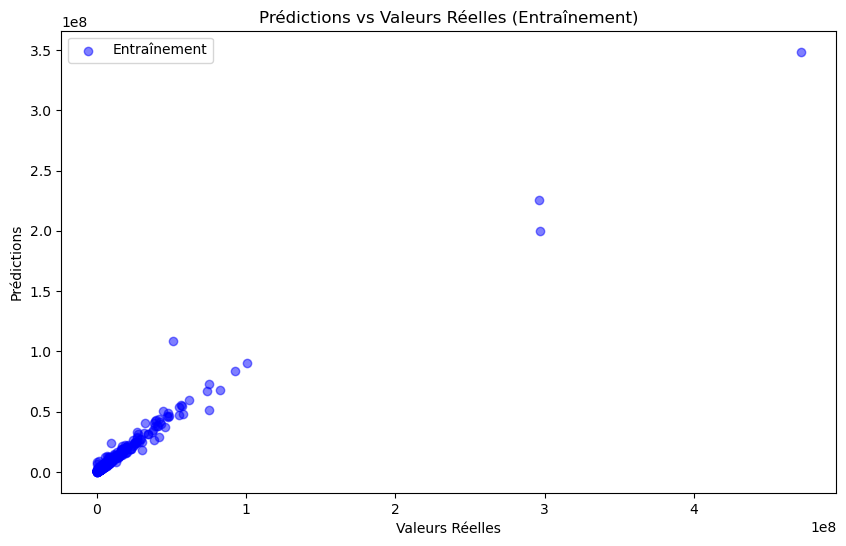

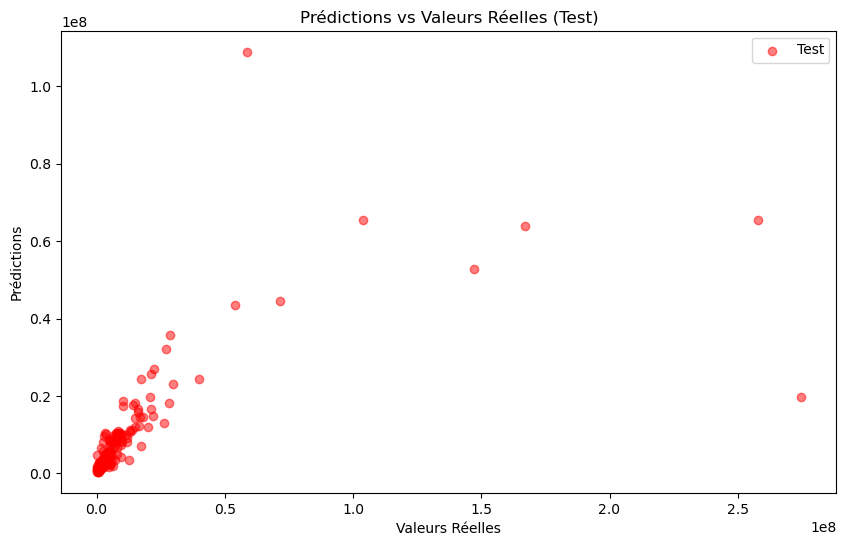

In [44]:
import matplotlib.pyplot as plt

# Plot des prédictions sur l'ensemble d'entraînement
plt.figure(figsize=(10, 6))
plt.scatter(y_train, best_forest_regressor.predict(X_train_final), color='blue', label='Entraînement', alpha=0.5)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles (Entraînement)')
plt.legend()
plt.show()

# Plot des prédictions sur l'ensemble de test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, color='red', label='Test', alpha=0.5)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.savefig('Prédictions.png')

plt.title('Prédictions vs Valeurs Réelles (Test)')
plt.legend()
plt.show()


In [ ]:
##shape

In [46]:
# Obtenez les valeurs SHAP pour chaque fonctionnalité
shap_feature_values = shap_values.values

# Afficher les valeurs SHAP pour chaque fonctionnalité
print("Valeurs SHAP pour chaque fonctionnalité:")
print(shap_feature_values)


Valeurs SHAP pour chaque fonctionnalité:
[[-4.06284209e+04 -8.85437256e+00 -9.39206270e+04 ...  5.40624409e+02
  -1.97864922e+04  0.00000000e+00]
 [-3.98641780e+04  7.40957400e+02 -3.82942014e+04 ...  4.80450009e+02
   4.96982207e+05  0.00000000e+00]
 [ 1.16062508e+04  4.15660263e+02 -1.03529595e+05 ...  5.99141569e+02
  -3.48626802e+04  0.00000000e+00]
 ...
 [ 6.87989572e+05  4.55466870e+06 -1.05746919e+06 ...  3.90646505e+02
  -2.67690694e+03  0.00000000e+00]
 [ 4.38512234e+03 -1.03706031e+03  1.92040830e+04 ...  6.70753068e+02
  -8.45695722e+03  0.00000000e+00]
 [-6.11310121e+04  5.96216937e+02 -9.64755209e+04 ...  8.08769759e+02
  -1.37587211e+04  0.00000000e+00]]


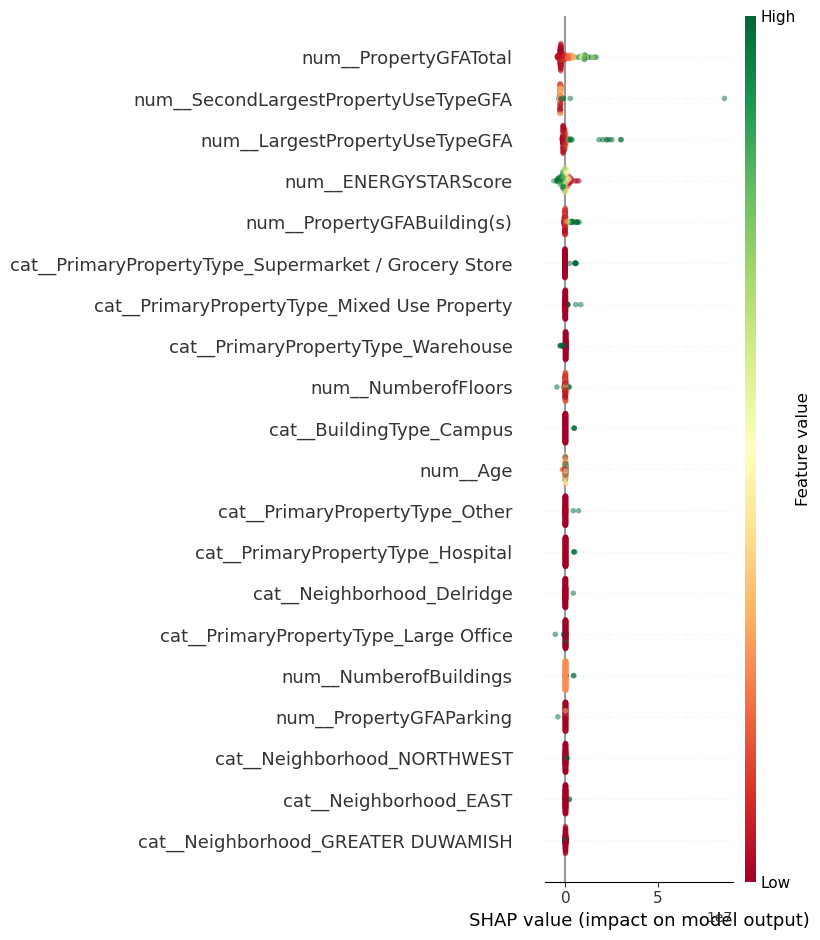

In [55]:
import shap

def random_forest_regression_shap(X_train_final, X_test_final, y_train, y_test, feature_names):
    # Créer et entraîner le modèle de Random Forest
    forest_regressor = RandomForestRegressor(random_state=42)
    forest_regressor.fit(X_train_final, y_train)

    # Expliquer les prédictions avec SHAP
    explainer = shap.Explainer(forest_regressor, X_train_final)
    shap_values = explainer(X_test_final)

    # Sauvegarder le plot SHAP
    shap.summary_plot(shap_values, X_test_final, feature_names=feature_names, show=False, plot_type='dot', color='green', alpha=0.5, cmap='RdYlGn')
    plt.savefig('shap_summary_plot.png')  # Sauvegarde l'image

    return forest_regressor, shap_values

# Appel de la fonction
# Sup noms de vos caractéristiques
model, shap_values = random_forest_regression_shap(X_train_final, X_test_final, y_train, y_test, feature_names)


In [56]:
# Obtenir les noms des fonctionnalités à partir de l'objet explainer
feature_names_shap = shap.TreeExplainer(model).feature_names
feature_names_shap

In [ ]:
la performace energetique influrence négativement la consommation totle d'énergie